In [12]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

train_ratio = 0.8
optuna_optimisation = False
# optuna_optimisation = True

external_data_path = "../data/external/"
image_path = "images/"

In [13]:
folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

In [14]:
min_ratings_per_movie = 50

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()

# First pass: count movie ratings
movie_rating_counts = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[1]
            movie_rating_counts[movie_id] = movie_rating_counts.get(movie_id, 0) + 1
except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during first pass: {e}")

# Filter movies by rating count
valid_movies = {movie_id for movie_id, count in movie_rating_counts.items() if count >= min_ratings_per_movie}

# Second pass: process ratings
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if movie_id not in valid_movies:
                continue  # Skip movies with too few ratings

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_train.append([])
                user_ratings_test.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([])
                movie_ratings_test.append([])

            user_idx = user_to_idx[user_id]
            movie_idx = movie_to_idx[movie_id]

            user_seen_before = len(user_ratings_train[user_idx]) > 0
            movie_seen_before = len(movie_ratings_train[movie_idx]) > 0

            if not user_seen_before or not movie_seen_before or random.random() < train_ratio:
                # Assign to training set
                user_ratings_train[user_idx].append((movie_idx, rating))
                movie_ratings_train[movie_idx].append((user_idx, rating))
                train_count += 1
            else:
                # Assign to test set (only if both user and movie are known from training)
                user_ratings_test[user_idx].append((movie_idx, rating))
                movie_ratings_test[movie_idx].append((user_idx, rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during second pass: {e}")

end_time = time.time()

# --- Logging ---
print("Finished")
print("Time taken:", round(end_time - start_time, 2), "seconds")
print("Train Count:", train_count)
print("Test Count:", test_count)
print("Unique Users:", len(user_to_idx))
print("Valid Movies (after filter):", len(movie_to_idx))


Finished
Time taken: 88.27 seconds
Train Count: 25242745
Test Count: 6255944
Unique Users: 200947
Valid Movies (after filter): 16034


In [15]:
file_name = "movies.csv" 
file_path = os.path.join(folder_name, file_name)

movie_id_to_movie_name = {}
movie_name_to_movie_id = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[0]
            movie_name = row[1]

            if movie_id not in movie_id_to_movie_name:
                movie_id_to_movie_name[movie_id] = movie_name
                movie_name_to_movie_id[movie_name] = movie_id

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [16]:
save_dir = os.path.join("..", "models")
save_path = os.path.join(save_dir, "recommender_model_params.npz")

# Load the model parameters
with np.load(save_path, allow_pickle=True) as data:
    user_embeddings = data['user_embeddings']
    item_embeddings = data['item_embeddings']
    user_biases = data['user_biases']
    item_biases = data['item_biases']

print("User Embeddings Shape:", user_embeddings.shape)
print("Item Embeddings Shape:", item_embeddings.shape)
print("User Biases Shape:", user_biases.shape)
print("Item Biases Shape:", item_biases.shape)

User Embeddings Shape: (200947, 10)
Item Embeddings Shape: (16034, 10)
User Biases Shape: (200947,)
Item Biases Shape: (16034,)


In [90]:
def predict_recommendations(user_embeddings, item_embeddings, item_biases, user_idx, model_id):
    predicted_rating = None
    if(model_id == "A"):
        predicted_rating = user_embeddings[user_idx] @ item_embeddings.T + item_biases
    else:
        predicted_rating = user_embeddings[user_idx] @ item_embeddings.T + (0.96 * item_biases)
    return predicted_rating

In [91]:
def createreco(user_idx: int, model_id: str, top_N: int = 15) -> list[tuple[int, float]]:
    predicted_ratings = predict_recommendations(user_embeddings, item_embeddings, item_biases, user_idx, model_id)
    top_movie_indices = np.argsort(predicted_ratings)[::-1][:top_N]
    
    recommendations = []
    for idx in top_movie_indices:
        movie_id = idx_to_movie[idx]
        score = predicted_ratings[idx]
        recommendations.append((movie_id, score))  # Return predicted score, not title
    
    return recommendations



In [92]:
def simulate_feedback(recommendations: list[tuple[int, str]], model_id: str) -> tuple[list[float], float]:
    # Simulate user rating each item on a scale of 1 to 5
    predicted_scores = np.array([score for _, score in recommendations])

    # Simulate feedback with noise around the predicted score
    feedback = predicted_scores + np.random.normal(loc=0.0, scale=1, size=len(predicted_scores))

    # Clip to 1–5 rating range
    feedback = np.clip(feedback, 1, 5)

    avg_rating = feedback.mean()
    return feedback.tolist(), avg_rating


In [93]:
def log_feedback(user_id, model_id, recs, feedbacks, precision, writer):
    for (movie_id, _), fb in zip(recs, feedbacks):
        writer.writerow([user_id, movie_id, fb, model_id, precision])


In [94]:
import random

NUM_USERS = 100
all_users = list(range(NUM_USERS))
group_A = random.sample(all_users, k=NUM_USERS // 2)
group_B = list(set(all_users) - set(group_A))

with open('feedback_log.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'movie_id', 'feedback', 'model_id', 'avg_rating'])

    for user_id in all_users:
        model_id = "A" if user_id in group_A else "B"
        recommendations = createreco(user_id, model_id)
        feedbacks, avg_rating = simulate_feedback(recommendations, model_id)
        log_feedback(user_id, model_id, recommendations, feedbacks, avg_rating, writer)



In [95]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

df = pd.read_csv('feedback_log.csv')

# Compute average rating per user
user_avg = df.groupby(['user_id', 'model_id'])['avg_rating'].mean().reset_index()

# Split groups
ratings_A = user_avg[user_avg['model_id'] == 'A']['avg_rating']
ratings_B = user_avg[user_avg['model_id'] == 'B']['avg_rating']

# T-test
t_stat, p_val = ttest_ind(ratings_A, ratings_B, equal_var=False)

print(f"Average Rating - A: {ratings_A.mean():.3f}")
print(f"Average Rating - B: {ratings_B.mean():.3f}")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.3f}")

alpha = 0.05  # significance level

if p_val < alpha:
    print("Statistically significant difference between A and B.")
else:
    print("No statistically significant difference.")


Average Rating - A: 2.240
Average Rating - B: 2.340
T-statistic: -1.455
P-value: 0.149
No statistically significant difference.


Running A/B Tests: 100%|██████████| 100/100 [04:59<00:00,  3.00s/it]


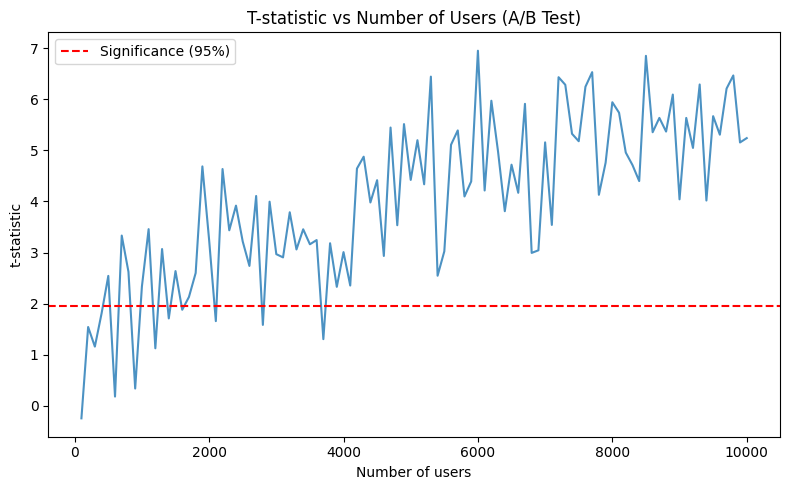

In [96]:
from tqdm import tqdm

def run_ab_test(num_users):
    all_users = list(range(num_users))
    group_A = random.sample(all_users, k=num_users // 2)
    group_B = list(set(all_users) - set(group_A))

    rows = []

    for user_id in all_users:
        model_id = "A" if user_id in group_A else "B"
        recommendations = createreco(user_id, model_id)
        feedbacks, avg_rating = simulate_feedback(recommendations, model_id)
        for (movie_id, _), fb in zip(recommendations, feedbacks):
            # Replace 'precision' with 'avg_rating'
            rows.append([user_id, movie_id, fb, model_id, avg_rating])

    df = pd.DataFrame(rows, columns=['user_id', 'movie_id', 'feedback', 'model_id', 'avg_rating'])

    # Compute average user rating per group
    user_avg = df.groupby(['user_id', 'model_id'])['avg_rating'].mean().reset_index()

    ratings_A = user_avg[user_avg['model_id'] == 'A']['avg_rating']
    ratings_B = user_avg[user_avg['model_id'] == 'B']['avg_rating']

    # Welch's t-test
    t_stat, _ = ttest_ind(ratings_A, ratings_B, equal_var=False)
    return t_stat


# Now run the test over increasing numbers of users
t_stats = []
user_counts = range(100, 10001, 100)  # from 100 to 10,000 in steps of 100

for n in tqdm(user_counts, desc="Running A/B Tests"):
    t = run_ab_test(n)
    t_stats.append(t)

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(user_counts, t_stats, alpha=0.8)
plt.axhline(y=1.96, color='red', linestyle='--', label='Significance (95%)')
plt.xlabel('Number of users')
plt.ylabel('t-statistic')
plt.title('T-statistic vs Number of Users (A/B Test)')
plt.legend()
plt.tight_layout()
plt.show()